In [2]:
import logging

import sys
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

from src.data_loader import LABEL_MAP
from src.data_loader import load_datasets
from src.model_pipeline import load_and_prep_datasets

plt.style.use('ggplot')

# Sentiment Analysis Mini-Challenge

> Authors: Dominik Filliger, Nils Fahrni, Noah Leuenberger (2024)

## 1. Introduction
Sentiment analysis is a crucial task in Natural Language Processing (NLP) that involves determining the sentiment or tone of a given text. It has numerous applications, such as understanding customer feedback, monitoring social media sentiment, and analyzing product reviews. However, manually labeling large datasets for sentiment analysis can be time-consuming and costly. Semi-supervised learning techniques, such as weak supervision, can help alleviate this challenge by leveraging a small amount of labeled data along with a larger set of unlabeled data to improve model performance.

 ## 2. Dataset Selection and Exploratory Data Analysis
The dataset used for this mini-challenge is the Amazon Polarity dataset, which consists of product reviews from Amazon labeled as either positive or negative. The dataset is loaded using the Hugging Face Datasets library. Exploratory data analysis is performed to gain insights into the distribution of labels, length of reviews, and other relevant characteristics.

As the dataset contains 4 million reviews we cut this down into a subset of 6666 reviews for the purpose of this mini-challenge. 666 of the reviews are used for validation, the remaining 6000 are split into 1000 labeled samples and 5000 artificially unlabeled samples.

Each subset has a 50/50 split of positive and negative reviews. 

In [3]:
train_df, unlabeled, validation = load_datasets("../data/partitions")

print(f"Labeled Dataset Length: {len(train_df)}")
print(f"Unlabeled Dataset Length: {len(unlabeled)}")
print(f"Validation Dataset Length: {len(validation)}")

Labeled Dataset Length: 250
Unlabeled Dataset Length: 2250
Validation Dataset Length: 277


To get a better idea of the whole dataset, we will merge the data again and perform some exploratory data analysis. For this purpose, we will merge the training, unlabeled, and validation datasets into one dataframe. We will also rename the 'ground_truth' column to 'label' in the unlabeled dataset to maintain consistency across the datasets.

In [4]:
unlabeled.rename(columns={'ground_truth': 'label'}, inplace=True)  # Rename column for consistency
eda_df = pd.concat([train_df, unlabeled, validation])
eda_df['label'] = eda_df['label'].map(LABEL_MAP)  # Map labels to 0: Negative, 1: Positive

print(f"Merged Dataset Length: {len(eda_df)}")
eda_df.head()

Merged Dataset Length: 2777


,label,title,content
2405659,positive,Wild and Crazy! What happens when you challeng...,Knitter's Magazine challenged their readers so...
2362469,negative,Stick with a normal boom mic,I bought a pair of these thinking they would b...
1892530,negative,Keep the single stars coming...,"...and click ""Yes"" that they were helpful to y..."
28368,positive,My children love this CD!,"The best night time CD for infants, toddlers a..."
1132910,negative,not good workmanship,one wing was only partially attached and other...


2024-06-07 15:52:51,351 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-07 15:52:51,351 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-07 15:52:51,355 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-07 15:52:51,356 - DEBUG - findfont: score(FontEntry(fname='/Users/nils/Documents/Classes/npr/npr-sentiment/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-06-07 15:52:51,356 - DEBUG - findfont: score(FontEntry(fname='/Users/nils/Documents/Classes/npr/npr-sentiment/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-06-07 15:5

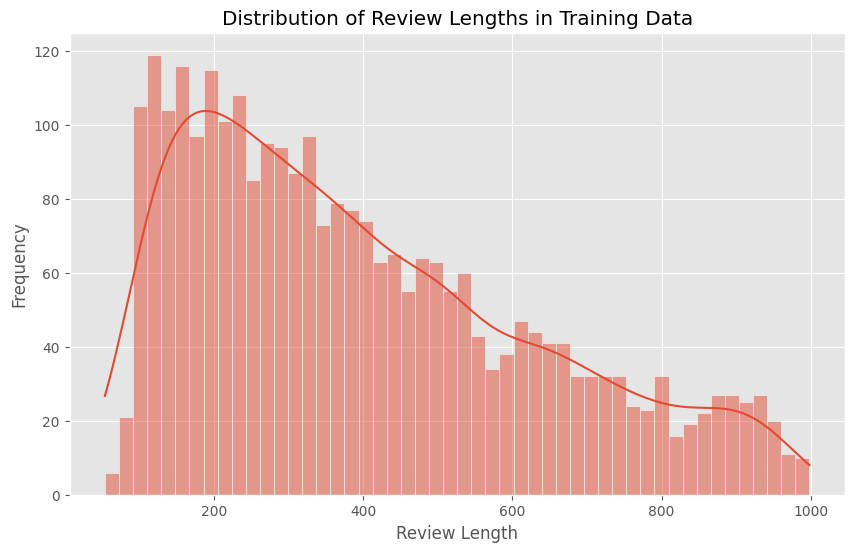

In [5]:
eda_df['review_length'] = eda_df['content'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(eda_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths in Training Data')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

The distribution of review lengths in the dataset is visualized using a histogram. The majority of reviews have a length between 0 and 1000 characters, with a peak around 500 characters. This information can be useful for preprocessing and feature engineering steps in the sentiment analysis task.

### Most Common Words

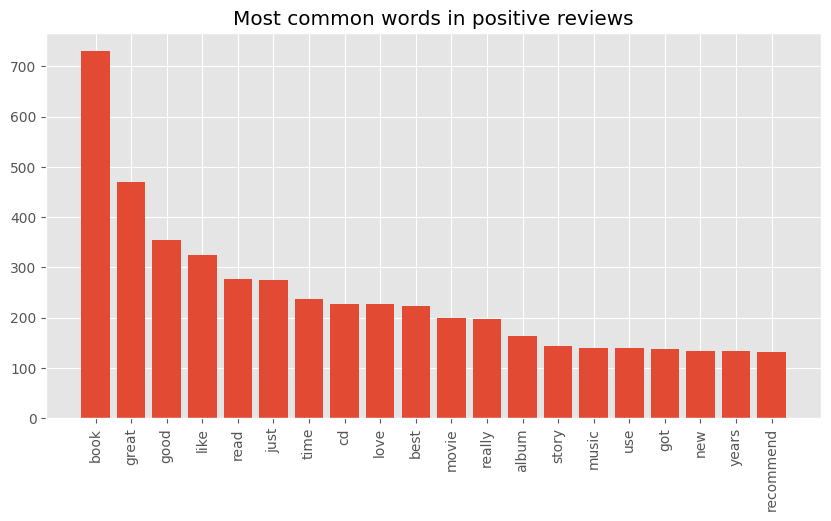

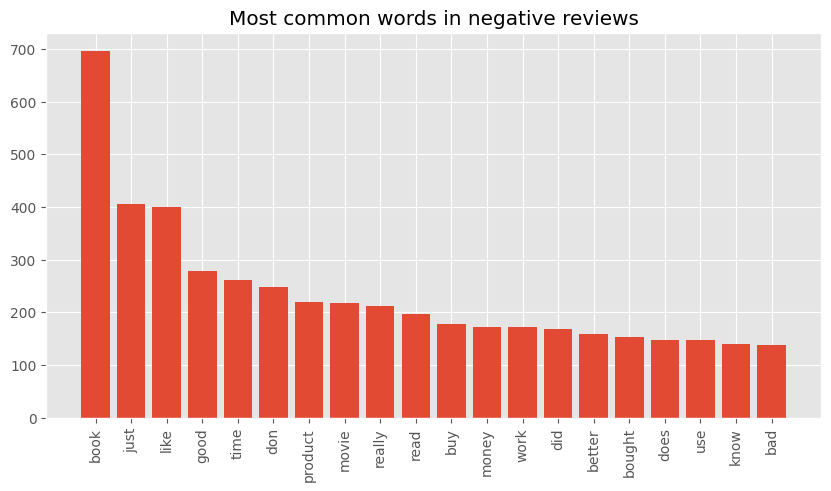

In [6]:
def plot_most_common_words(df, top_n=20):
    df = df.copy()
    df['label'] = df['label'].map({v: k for k, v in LABEL_MAP.items()})
    pos_reviews = df[df['label'] == 1]['content']
    neg_reviews = df[df['label'] == 0]['content']

    vectorizer_pos = CountVectorizer(stop_words='english')
    vectorizer_neg = CountVectorizer(stop_words='english')

    pos_word_count = vectorizer_pos.fit_transform(pos_reviews)
    neg_word_count = vectorizer_neg.fit_transform(neg_reviews)

    pos_sum_words = pos_word_count.sum(axis=0)
    neg_sum_words = neg_word_count.sum(axis=0)

    pos_words_freq = [(word, pos_sum_words[0, idx]) for word, idx in
                      zip(vectorizer_pos.get_feature_names_out(), range(pos_sum_words.shape[1]))]
    neg_words_freq = [(word, neg_sum_words[0, idx]) for word, idx in
                      zip(vectorizer_neg.get_feature_names_out(), range(neg_sum_words.shape[1]))]

    pos_words_freq = sorted(pos_words_freq, key=lambda x: x[1], reverse=True)
    neg_words_freq = sorted(neg_words_freq, key=lambda x: x[1], reverse=True)

    words, freq = zip(*pos_words_freq[:top_n])
    plt.figure(figsize=(10, 5))
    plt.bar(words, freq)
    plt.title('Most common words in positive reviews')
    plt.xticks(rotation=90)
    plt.show()

    words, freq = zip(*neg_words_freq[:top_n])
    plt.figure(figsize=(10, 5))
    plt.bar(words, freq)
    plt.title('Most common words in negative reviews')
    plt.xticks(rotation=90)
    plt.show()


plot_most_common_words(eda_df, top_n=20)

The most common words in positive and negative reviews are visualized using bar plots. The top 20 most frequent words in each category are displayed, providing insights into the language used in positive and negative reviews.

### Word Clouds

In [7]:
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=set(STOPWORDS),
                          min_font_size=10).generate(text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title)
    plt.show()

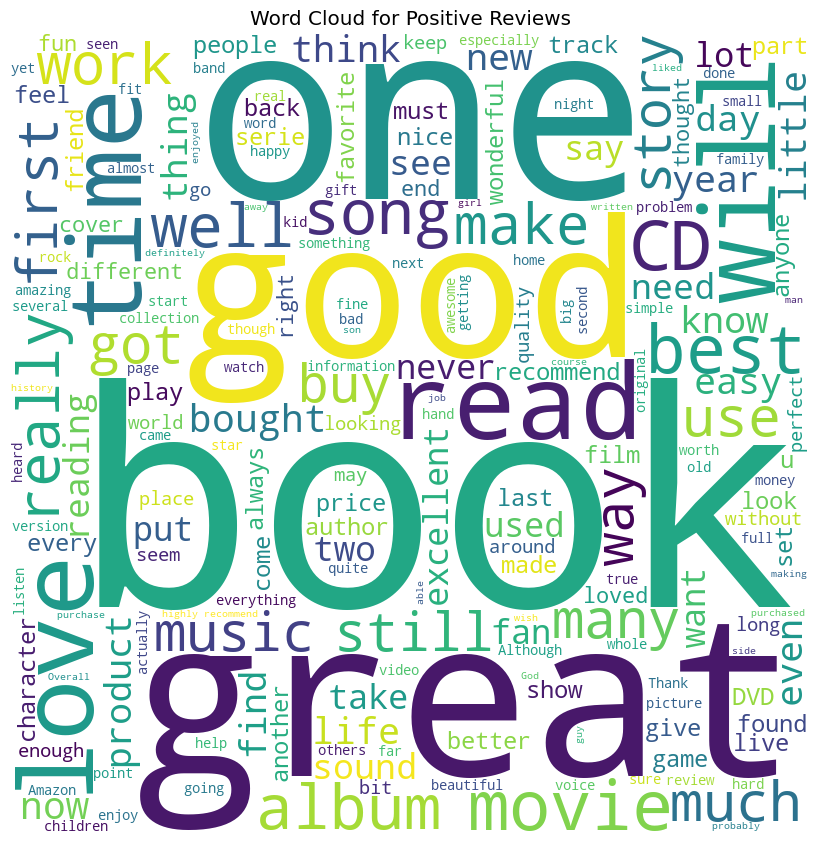

In [8]:
pos_reviews_text = " ".join(eda_df[eda_df['label'] == "positive"]['content'].values)
generate_word_cloud(pos_reviews_text, "Word Cloud for Positive Reviews")

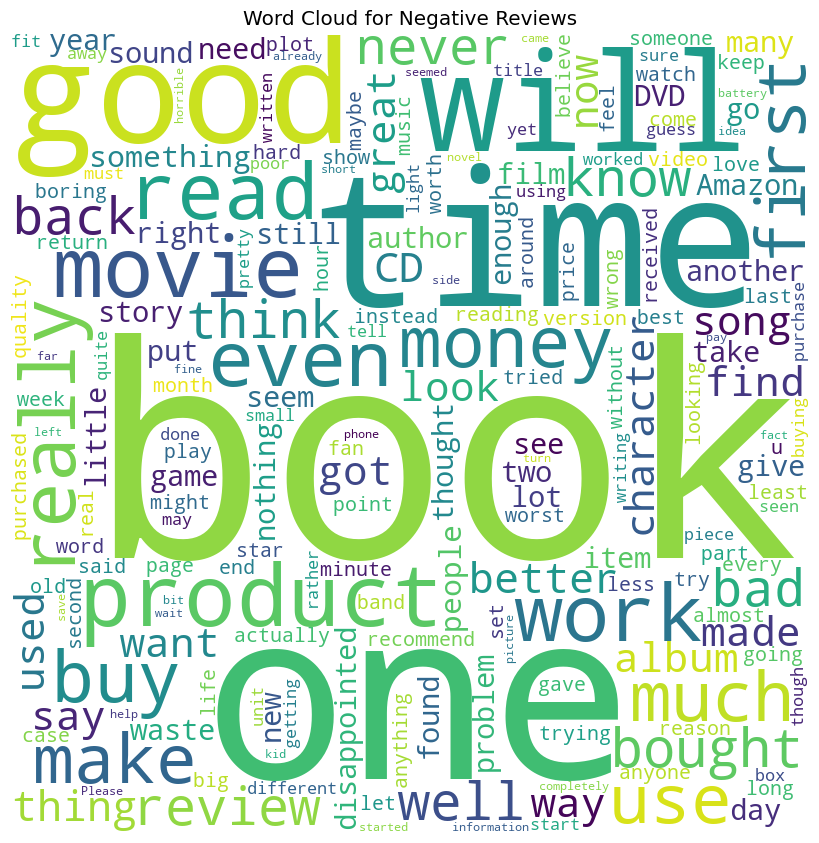

In [9]:
neg_reviews_text = " ".join(eda_df[eda_df['label'] == "negative"]['content'].values)
generate_word_cloud(neg_reviews_text, "Word Cloud for Negative Reviews")

## 3. Data Splitting Strategy
The dataset is split into development, validation, labeled, and unlabeled sets using a nested split approach. The development set is a fraction of the full dataset, the validation set is a fraction of the test dataset, and the labeled set is a fraction of the development set. The remaining samples in the development set are considered unlabeled. The nested split always adds in 25% increments (25, 50, 75), and a 1/6 split between labeled and unlabeled data is used, resulting in 1000 labeled and 5000 weakly labeled samples in total.

All the pre-split datasets are stored in the `data/partitions` directory as `.parquet` files.

Given the focus of the MC on the impact of weak labeling and its impact, we introduce a nested split which further divides our training data into splits. Here is a brief overview of the nested split algorithm we use:

1. **Validate the Fractions**: We start by ensuring that the proportions we want to use for our subsets are reasonable—each should be a fraction of the whole dataset.
2. **Shuffle the Data**: To make sure our subsets are representative and unbiased, we randomly shuffle the entire dataset. This ensures that each subset is a good mix of the data.
3. **Forming the Subsets**: For each proportion we decided on, we calculate how much of the dataset it represents. Starting with the smallest subset, we keep adding more data until we reach the desired size for each proportion. Each new subset contains all the data from the previous subsets, plus some more.
4. **Collect the Subsets**: In the end, we have a series of nested subsets, each larger than the last.

The implementation of the nested split is used in the `load_and_prep_datasets` function in the `src/model_pipeline.py` module and separately implemented in the `src/prep_datasets.py` script.

As the goal is to identify the optimal amount of additional data that can be used to improve model performance without the need for manual annotation. For this purpose: When training with weak labels we only apply the nested split on the weak labels and not the labeled data and then concat every given nested split with all the labeled data.

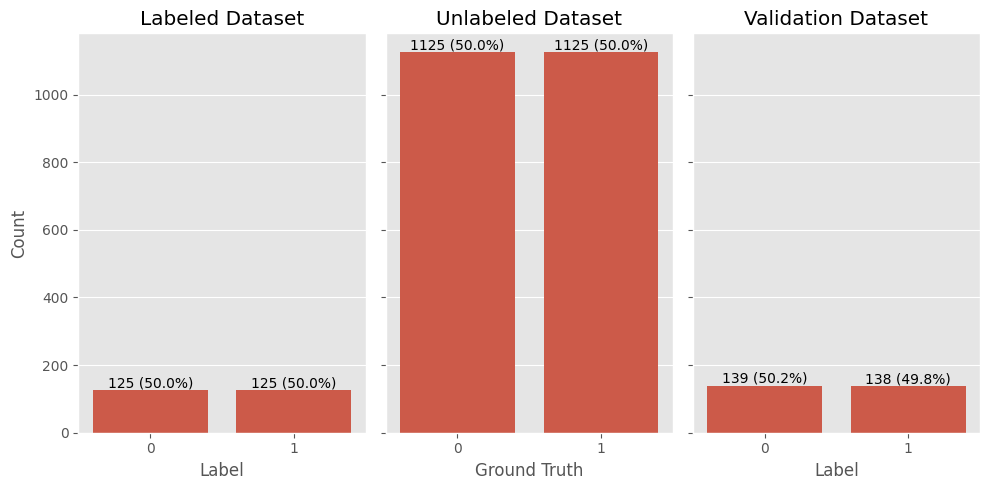

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharey=True)


def add_percentages(ax, data, percentages=True):
    total = len(data)
    for p in ax.patches:
        height = int(p.get_height())
        if percentages:
            label = f'{height} ({(height / total) * 100:.1f}%)'
        else:
            label = f'{height}'
        ax.text(p.get_x() + p.get_width() / 2., height, label, ha='center', va='bottom')


sns.countplot(data=train_df, x='label', ax=ax[0])
add_percentages(ax[0], train_df)
ax[0].set_title('Labeled Dataset')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count')

sns.countplot(data=unlabeled, x='label', ax=ax[1])
add_percentages(ax[1], unlabeled)
ax[1].set_title('Unlabeled Dataset')
ax[1].set_xlabel('Ground Truth')

sns.countplot(data=validation, x='label', ax=ax[2])
add_percentages(ax[2], validation)
ax[2].set_title('Validation Dataset')
ax[2].set_xlabel('Label')

plt.tight_layout()
plt.show()

The distribution of labels in the labeled, unlabeled, and validation datasets is visualized using count plots. The percentage of positive and negative reviews in each dataset is displayed, providing insights into the class distribution of the data. As we can see, the datasets are balanced with a 50/50 split between positive and negative reviews making imbalanced classes no issue for our models.

2024-06-07 15:52:56,614 - INFO - Loaded datasets from ../data/partitions: 250 training samples, 277 validation samples
2024-06-07 15:52:56,634 - INFO - Created nested splits: ['0.25', '0.5', '0.75', '1.0']


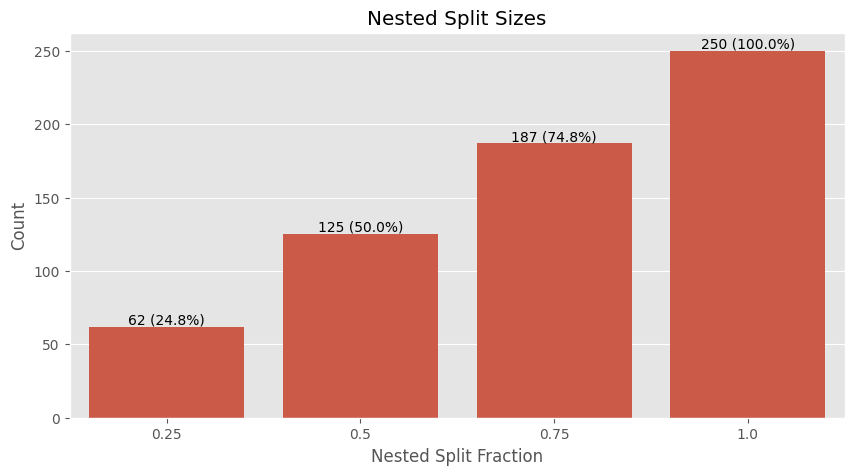

In [11]:
preped_datasets = load_and_prep_datasets("../data", nested_splits=True)
logging.disable(
    logging.CRITICAL)  # Disable logging for this cell as logging is initialized in the load_and_prep_datasets function

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(x=list(preped_datasets['nested_splits'].keys()),
            y=[len(value) for value in preped_datasets['nested_splits'].values()], ax=ax)
ax.set_title('Nested Split Sizes')
ax.set_xlabel('Nested Split Fraction')
ax.set_ylabel('Count')

total = len(preped_datasets['train'])

add_percentages(ax, preped_datasets['train'])

plt.show()

The sizes of the nested splits generated from the training data are visualized using a bar plot. The count of samples in each nested split is displayed, along with the percentage of the total training data that each split represents. The nested splits are created in 25% increments, starting from 25% of the training data and increasing to 100% of the training data. In this visualization the nested split was only applied to the labeled data but the picture would be the same if it was applied to the weak labels.

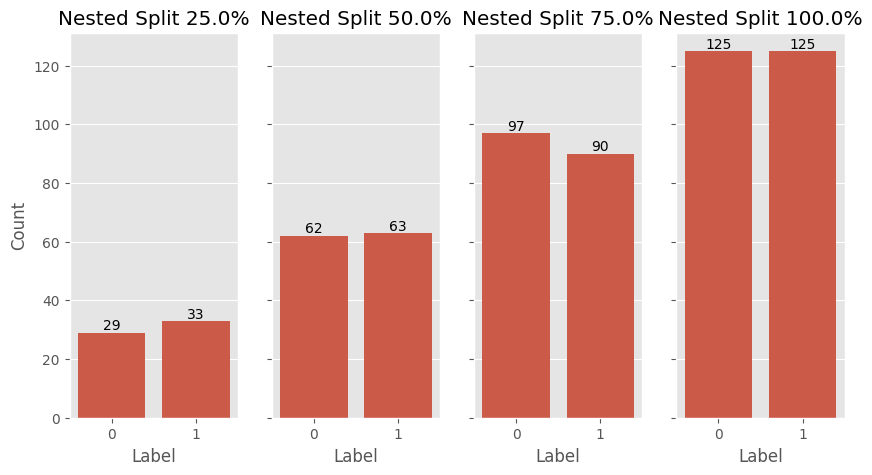

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), sharey=True)

for i, (key, value) in enumerate(preped_datasets['nested_splits'].items()):
    value = value.to_pandas()
    sns.countplot(data=value, x='label', ax=ax[i])
    add_percentages(ax[i], value, percentages=False)
    ax[i].set_title(f'Nested Split {float(key)*100}%')
    ax[i].set_xlabel('Label')
    ax[i].set_ylabel('Count')

The distribution of labels in each nested split is visualized using count plots. The percentage of positive and negative reviews in each nested split is displayed, providing insights into the class distribution of the data. The nested splits maintain a balanced distribution of positive and negative reviews, as the set the data is sampled from is also balanced.

## Helper Functions
In order to make the notebook more readable and to avoid code duplication, we will define some helper functions that will be used throughout the notebook. These functions will help us to perform common tasks such as running experiments, evaluating pipelines, and visualizing the results.


In [13]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

import os
from dotenv import load_dotenv
load_dotenv()

MODEL_DIR = os.getenv("MODELS_DIR")

def plot_additional_metrics(results_data, model_names):
    fig = plt.figure(figsize=(16, 13))
    gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[3, 1.5, 1.5], wspace=0.3, hspace=0.6)

    # Precision-Recall curve
    ax_pr = fig.add_subplot(gs[0, 0])
    for i, model_results in enumerate(results_data):
        precision, recall, _ = precision_recall_curve(model_results['eval_true_labels'], model_results['eval_pred_probs'])
        auprc = auc(recall, precision)
        ax_pr.plot(recall, precision, label=f'{model_names[i]} (AUPRC = {auprc:.2f})')
    ax_pr.set_title('Precision-Recall Curve', fontsize=14, pad=15)
    ax_pr.set_xlabel('Recall', fontsize=12, labelpad=10)
    ax_pr.set_ylabel('Precision', fontsize=12, labelpad=10)
    ax_pr.legend(loc='lower left', fontsize=11, bbox_to_anchor=(0.0, 0.0), borderaxespad=0.5)
    ax_pr.grid(True)

    # ROC curve and AUC
    ax_roc = fig.add_subplot(gs[0, 1])
    for i, model_results in enumerate(results_data):
        fpr, tpr, _ = roc_curve(model_results['eval_true_labels'], model_results['eval_pred_probs'])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title('ROC Curve', fontsize=14, pad=15)
    ax_roc.set_xlabel('False Positive Rate', fontsize=12, labelpad=10)
    ax_roc.set_ylabel('True Positive Rate', fontsize=12, labelpad=10)
    ax_roc.legend(loc='lower right', fontsize=11, bbox_to_anchor=(1.0, 0.0), borderaxespad=0.5)
    ax_roc.grid(True)

    # Confusion matrices
    for i, model_results in enumerate(results_data):
        ax_cm = fig.add_subplot(gs[1 + i // 2, i % 2])
        cm = model_results['eval_confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cbar=False, annot_kws={"size": 14})
        ax_cm.set_title(f'Confusion Matrix - {model_names[i]}', fontsize=13, pad=15)
        ax_cm.set_xlabel('Predicted', fontsize=11, labelpad=10)
        ax_cm.set_ylabel('True', fontsize=11, labelpad=10)
        ax_cm.tick_params(axis='both', labelsize=11)

    plt.tight_layout()
    plt.show()    

def plot_model_performance(results_data, model_names, baseline_data=None, baseline_name='Baseline'):

    results = results_data

    fractions = sorted(results[0].keys(), key=float)
    num_fractions = len(fractions)

    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(num_fractions)

    if baseline_data:
        baseline_accuracy = baseline_data['eval_accuracy']
        baseline_f1 = baseline_data['eval_f1_weighted']
        ax.axhline(y=baseline_accuracy, color='r', linestyle='--', label=baseline_name)
        ax.axhline(y=baseline_f1, color='g', linestyle='--', label=f'{baseline_name} (F1-Score Weighted)')

    for i, model_results in enumerate(results):
        values = [model_results[fraction]['eval_accuracy'] for fraction in fractions]
        values_f1 = [model_results[fraction]['eval_f1_weighted'] for fraction in fractions]
        ax.plot(x, values, marker='o', label=model_names[i])
        ax.plot(x, values_f1, marker='x', label=f'{model_names[i]} (F1-Score Weighted)')

    ax.set_xticks(x)
    ax.set_xticklabels(fractions)
    ax.set_xlabel('Fraction of Labeled Samples')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy Comparison')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')
    ax.grid(True)

    plt.tight_layout()
    plt.show()


## 4. Baseline Model Performance
The selected model is a pretrained language model, specifically `sentence-transformers/all-MiniLM-L6-v2`, which is used as the baseline model for sentiment classification without any training. 
   
Before we train any models, we will evaluate the performance of the baseline model on the validation set. The model will be used to predict the sentiment of the reviews in the validation set, and the results will be evaluated using accuracy, precision, recall, and F1-score metrics.

**DISCLAIMER**: In this notebook no training or evaluating is done it. It only loads the results from the training and evaluation done via the `src/model_pipeline.py` module. For more info check out the README file.

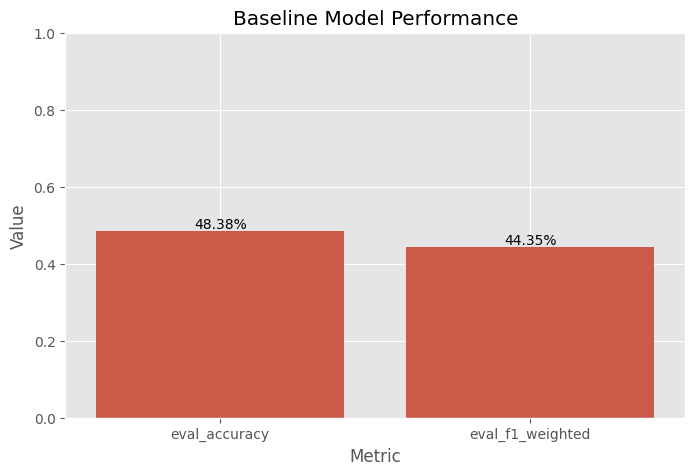

In [29]:
import json

relevant_metrics = ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1_weighted']

with open(f'{MODEL_DIR}/eval/eval_results.json') as file:
    baseline_data = json.load(file)

metrics = [metric for metric in relevant_metrics if metric in baseline_data]
values = [baseline_data[metric] for metric in metrics]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.barplot(x=metrics, y=values, ax=ax)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height, f'{height*100:.2f}%', ha='center', va='bottom')

ax.set_title('Baseline Model Performance')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_ylim(0, 1)

ax.grid(True, zorder=-1)
plt.show()

The results speak for themselves. The model without any training achieves very poor results. With around 50% accuracy, it is only slightly better than random guessing.

This sets the perfect foundation for our experiments. 


## 5. Supervised Learning Performance

Before we dive deeper into the chosen weak labeling technique and its impact on the model performance, we will first decide whether we will train our model via transfer learning or fine-tuning.

For this we will train the model using the nested splits on both techniques and compare the results. The results are stored in the `data/eval` directory as `.json` files.


### 5.1 Transfer Learning

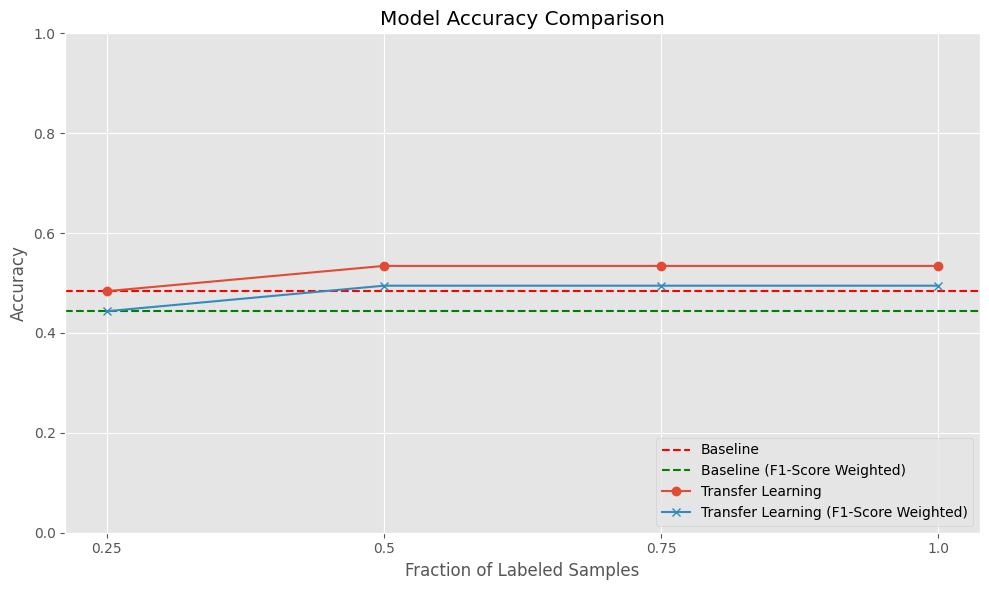

In [15]:
with open(f'{MODEL_DIR}/supervised/transfer_nested/eval_results.json') as file:
    transfer_nested_data = json.load(file)

plot_model_performance([transfer_nested_data], ['Transfer Learning'], baseline_data)



The results show that the transfer learning model barely outperforms the baseline model. This indicates that the pretrained model's knowledge is not sufficient to achieve high performance on the sentiment analysis task. 

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_13751/2776360340.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


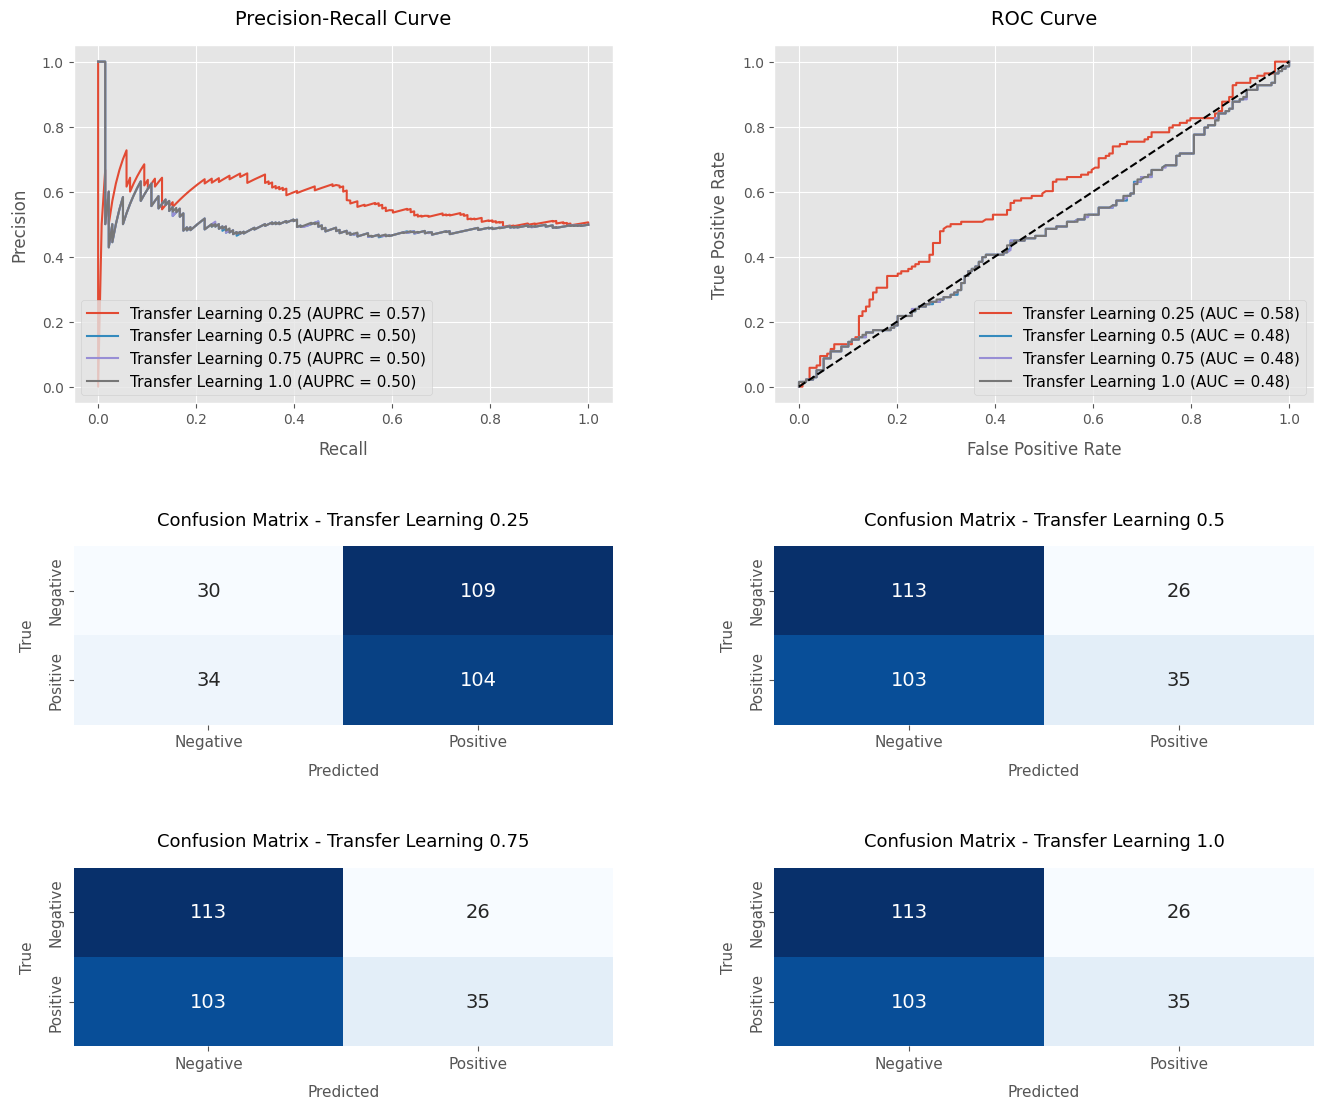

In [16]:
plot_additional_metrics([results for k, results in transfer_nested_data.items()], [f'Transfer Learning {percentage}' for percentage in transfer_nested_data.keys()])

### 5.2 Fine-tuning
To identify if fine-tuning the model can improve the performance, we will train the model using the nested splits and compare the results. 

For the fine-tuning we are using the recommended hyperparameters from the Hugging Face documentation. 

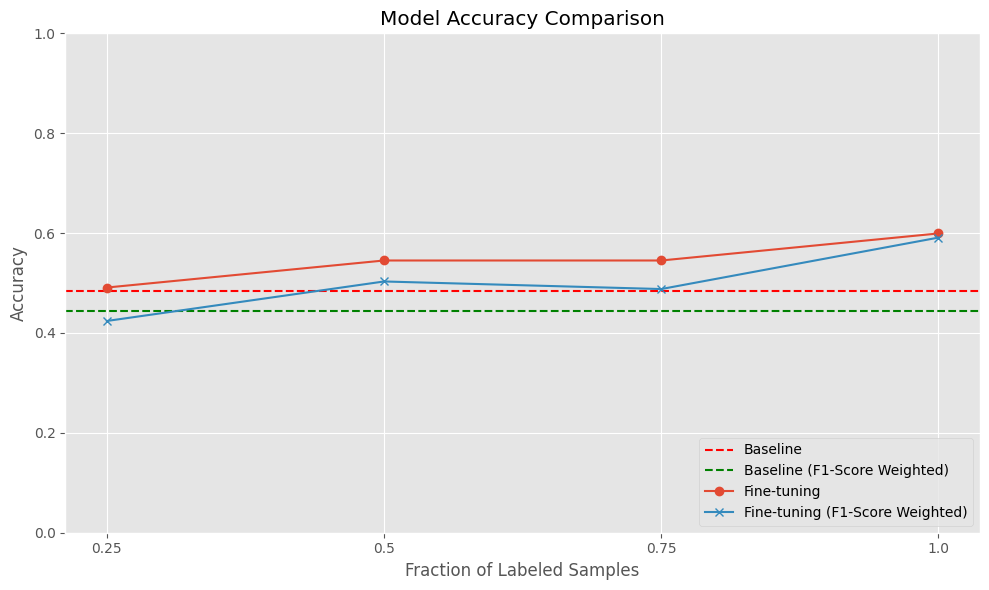

In [17]:
with open(f'{MODEL_DIR}/supervised/finetune_nested/eval_results.json') as file:
    finetune_nested_data = json.load(file)

plot_model_performance([finetune_nested_data], ['Fine-tuning'], baseline_data)


The results show that fine-tuning outperforms both the baseline model and the transfer learning model. We can also see that after using 75% of the labeled data (750 labeled samples) the model stagnates in its performance. This indicates that the model has reached its capacity to learn from the data and adding more data does not substantially improve the performance.


/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_13751/2776360340.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


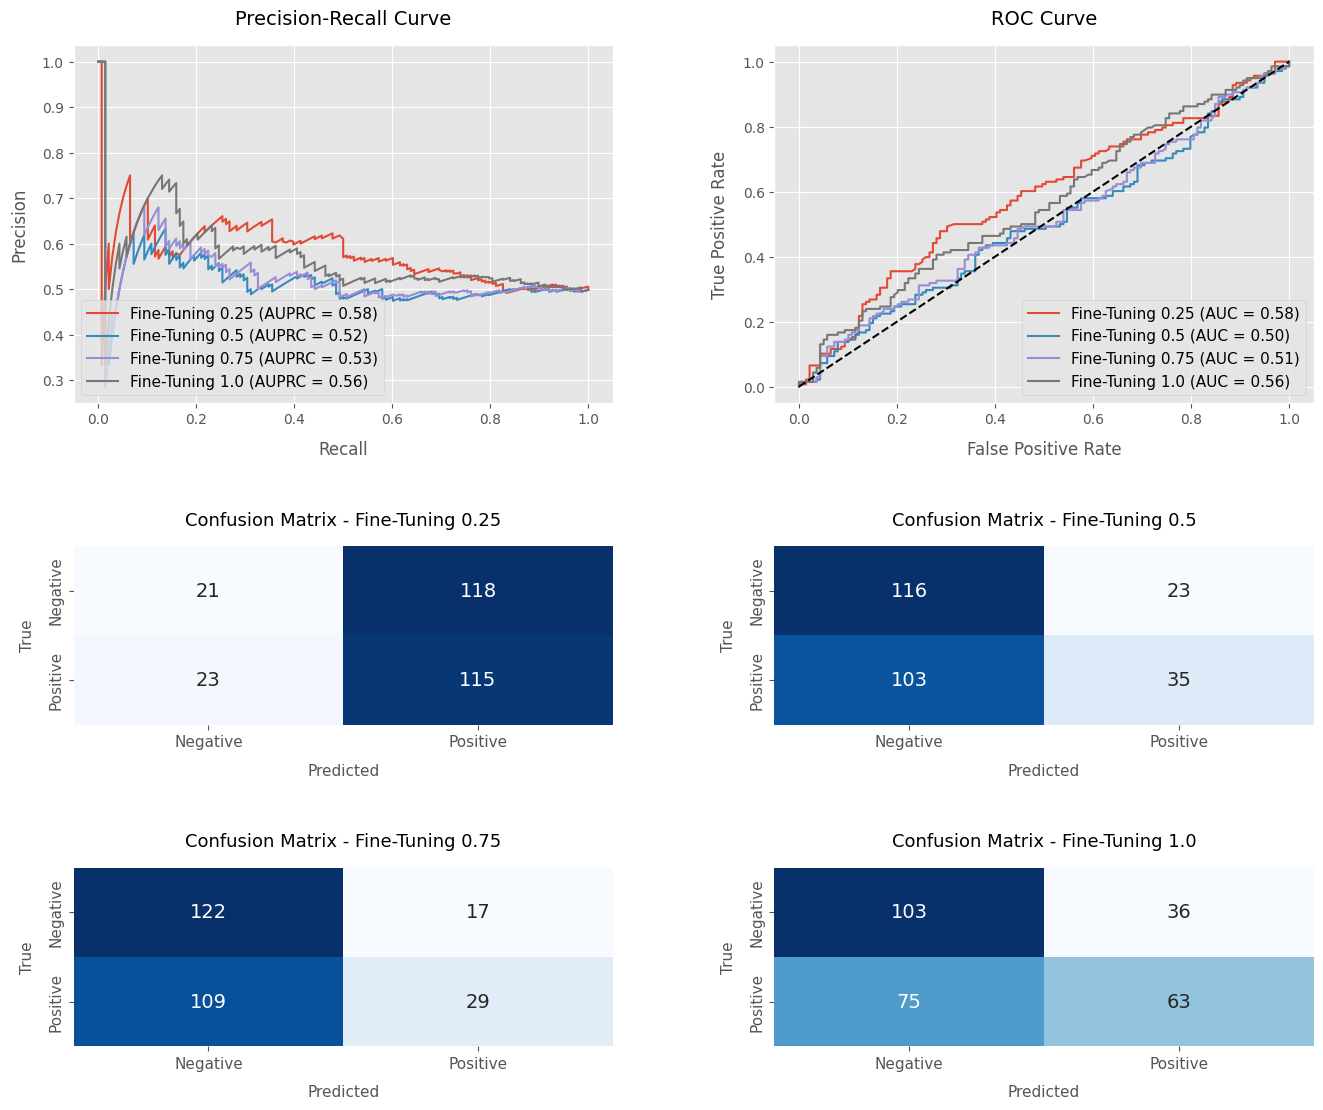

In [18]:
plot_additional_metrics([results for k, results in finetune_nested_data.items()], [f'Fine-Tuning {percentage}' for percentage in finetune_nested_data.keys()])

## 6. Semi-Supervised Learning Performance
After we established that fine-tuning is the best approach for training the model, we will now evaluate the performance of the semi-supervised learning techniques. We will compare the performance of the fine-tuned model with weak labels generated using different weak labeling strategies. 

The nested split logic above is used, with the small difference that each split contains the fully labeled data. This means that the nested split is applied to the weak labels and then concatenated with the fully labeled data. 

### 6.1 Logistic Regression (LogReg) Weak labeling

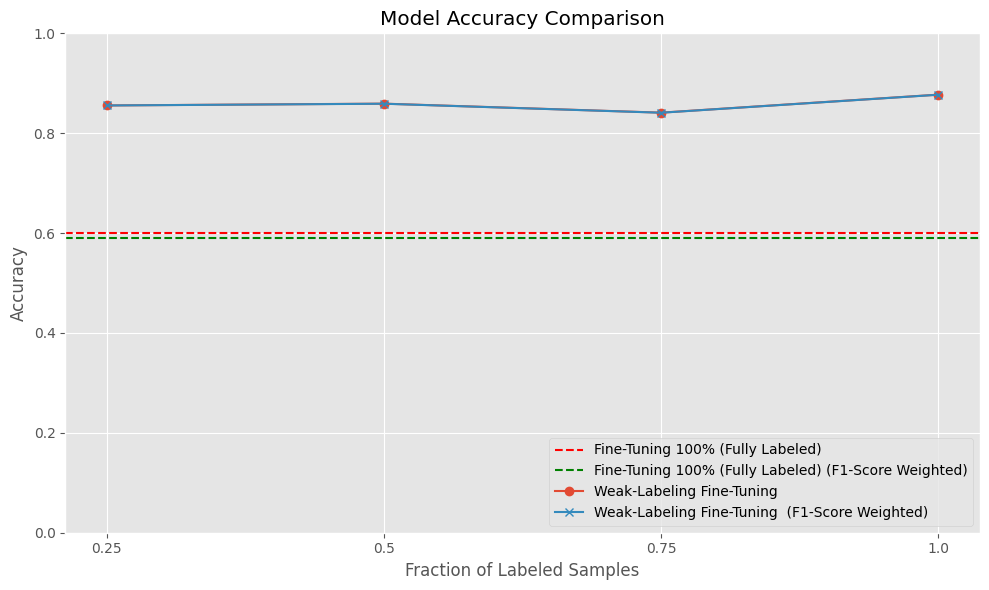

In [19]:
with open(f'{MODEL_DIR}/semi-supervised/finetune_nested/eval_results.json') as file:
    logreg_nested_data = json.load(file)
    
plot_model_performance([logreg_nested_data], ['Weak-Labeling Fine-Tuning '], finetune_nested_data["1.0"], baseline_name='Fine-Tuning 100% (Fully Labeled)')


Adding weak labels to the dataset has a significant impact on the model performance. With only an additional 25% of weakly labeled (total 812, 250 labeled and 562 weakly labeled) data, the model achieves an accuracy of around 88%. This is a substantial improvement compared to the fine-tuning model, which only used the fully labeled data. 

However, we can also see an interesting pattern, the difference between 25% and 100% additional weak labels has little to no impact. This indicates that the model has reached its capacity to learn from the data and adding more data does not substantially improve the performance. We even spot a slight decrease in performance when at 75% weak labels.


/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_13751/2776360340.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


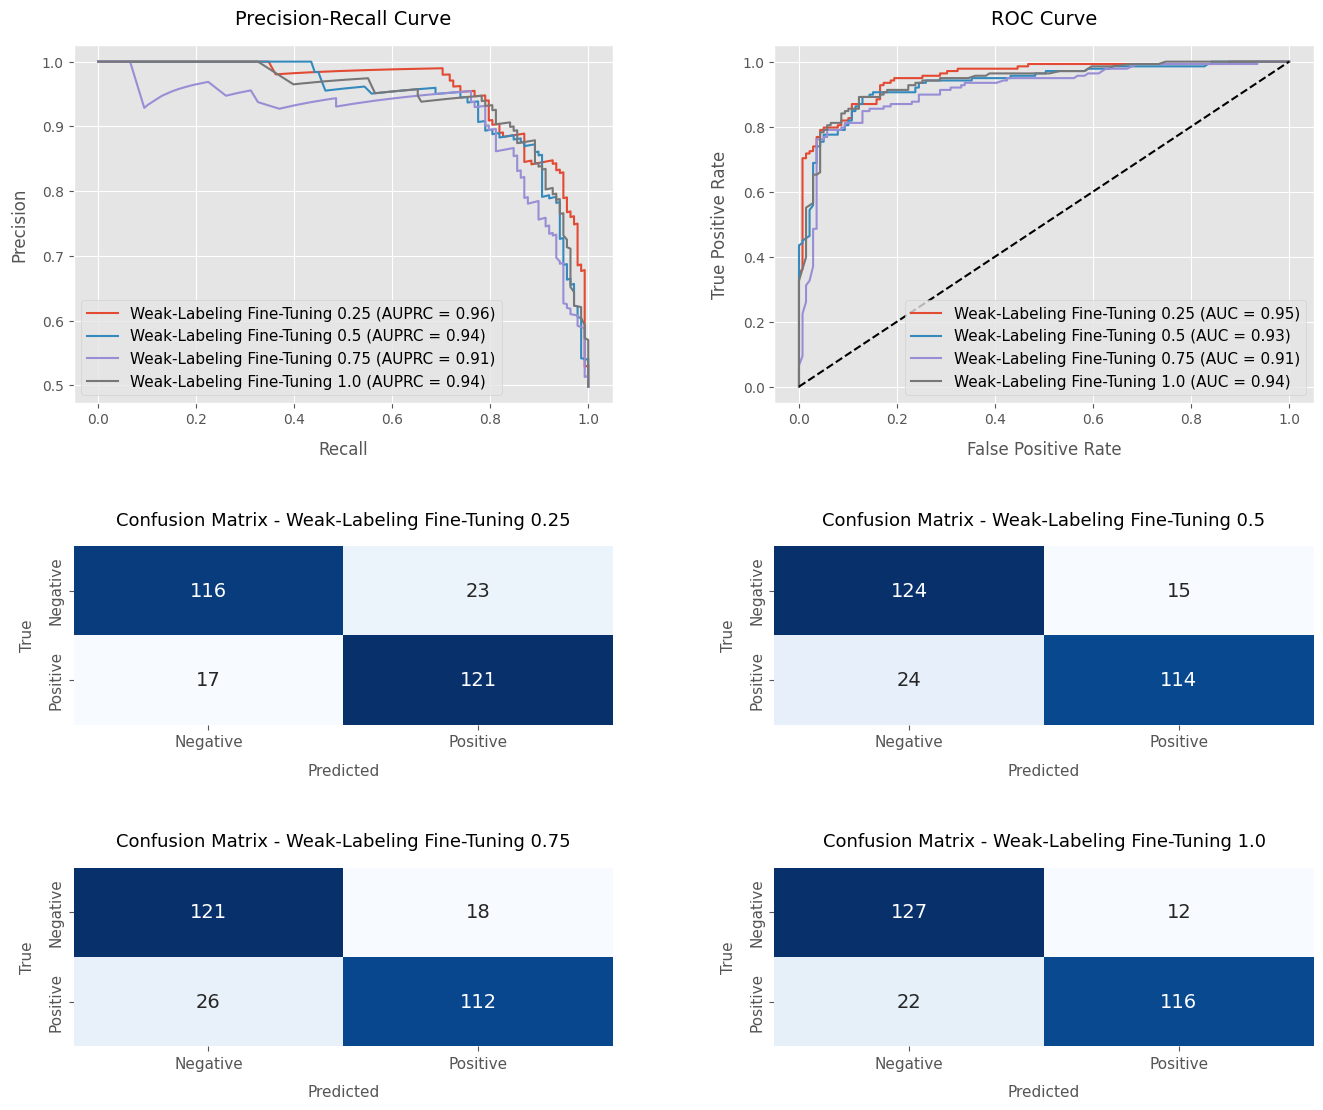

In [20]:
plot_additional_metrics([results for k, results in logreg_nested_data.items()], [f'Weak-Labeling Fine-Tuning {percentage}' for percentage in logreg_nested_data.keys()])

## 8. Model Comparison and Analysis
A thorough analysis of the results is conducted, comparing the baseline model, supervised learning techniques, and semi-supervised learning techniques. The impact of different weak labeling strategies and training data sizes on model performance is evaluated. The best approach for the chosen dataset is determined, emphasizing the models that achieve acceptable performance with few manually annotated samples.

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_13751/2776360340.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


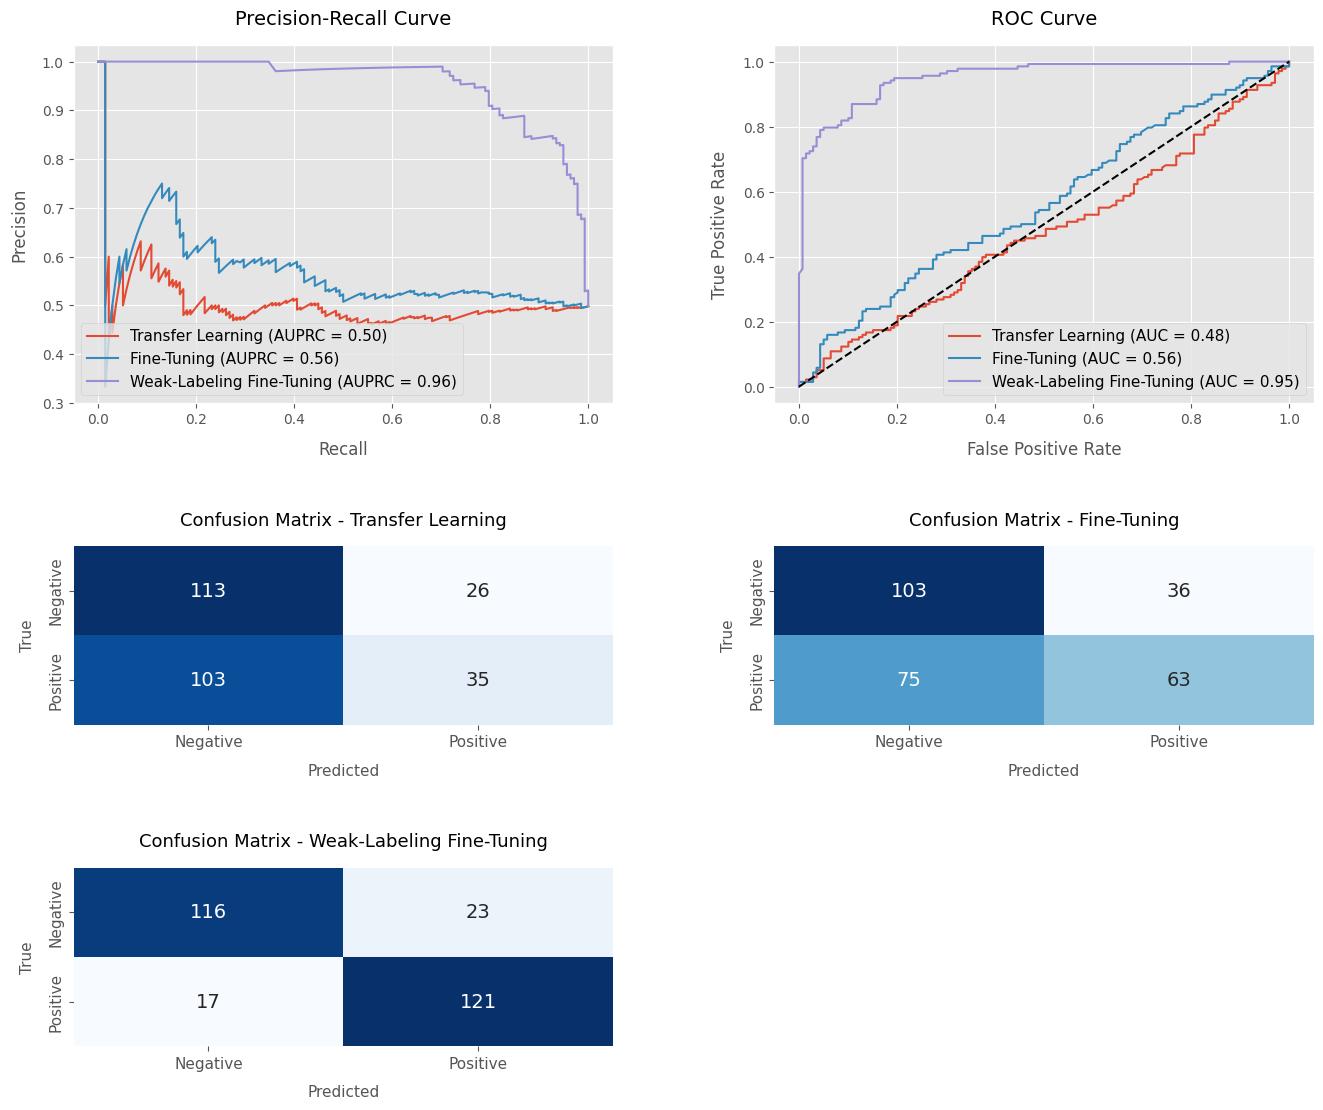

In [21]:
with open(f'{MODEL_DIR}/semi-supervised/finetune_nested/eval_results.json') as file:
    logreg_nested_data = json.load(file)

best_transfer = transfer_nested_data["1.0"]
best_finetune = finetune_nested_data["1.0"]
best_weak_labeling = logreg_nested_data["0.25"]


plot_additional_metrics([best_transfer, best_finetune, best_weak_labeling], ['Transfer Learning', 'Fine-Tuning', 'Weak-Labeling Fine-Tuning'])